In [1]:
import numpy as np
import pandas as pd
import astroquery
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
from numpy.random import poisson, beta, uniform

import occSimFuncs as occFunc
from tvguide import TessPointing

from astropy.coordinates import SkyCoord
from astropy import units as u

%matplotlib inline

In [2]:
msun = 1.9891E30
rsun = 695500000.
G = 6.67384E-11
AU = 149597870700.

consts = {'sigma_threshold': 7.3}

def get_insol(teff, ars):
    p1 = (teff/5771)**4
    p2 = (215.1 / ars)**2
    return p1 * p2

In [3]:
fn = '../data/fiducial6-2min.csv.bz2'

newDF = pd.read_csv(fn)

In [4]:
newDF['nsectors'] = np.round(newDF.obs_len/27.4)

In [5]:
newDF['detected'] = (newDF.noise_level < newDF.needed_for_detection) & (newDF.Ntransits >= 3) & (newDF.planetRadius > 0.0) & newDF.has_transits
total_planets = newDF.detected.sum()
print(total_planets)
detected_DF = newDF[newDF.detected == True]

brightstar_DF = detected_DF[detected_DF.TESSMAG < 11.]
coolstar_DF = detected_DF[detected_DF.TEFF < 3900]
verycool_df = detected_DF[detected_DF.TEFF < 3410]

990


In [6]:
q = [print('{}: {} & {} & {}'.format(x,*np.percentile(detected_DF.loc[:,x], [50,5,95], axis=0))) for x in detected_DF.columns]

Unnamed: 0: 1888353.0 & 73979.6 & 3335508.55
Unnamed: 0.1: 87526.0 & 9478.900000000001 & 230555.49999999988
Unnamed: 0.1.1: 107154.0 & 12683.300000000001 & 279198.69999999984
RA: 182.57428834300003 & 22.191646971865005 & 338.9174489313
DEC: 1.8406220000000002 & -74.42281755782 & 75.44009638249999
TESSMAG: 10.406500000000001 & 7.1348 & 13.41385
TEFF: 5391.5 & 3166.7 & 7089.749999999999
PRIORITY: 0.00361669382941 & 0.0018020654893940004 & 0.014681477085949987
RADIUS: 0.983554 & 0.222 & 2.6829584999999994
MASS: 0.939032960082 & 0.197 & 1.6002055
CONTRATIO: 0.009193144007434999 & 0.00016342461850119998 & 0.23600190234624976
ECLONG: 182.78758549 & 23.095443089 & 339.50389330249993
ECLAT: 8.068034999999998 & -79.8703626705 & 79.33993407349999
V: 11.283 & 7.63755 & 16.388650000000002
Ks: 9.088000000000001 & 6.399 & 10.947
TICID: 233068551.0 & 24598353.5 & 445813896.6
SELECTED: 1.0 & 1.0 & 1.0
tess_ccd: 2.0 & 1.0 & 4.0
obs_len: 54.8 & 27.4 & 356.2
isMdwarf: 0.0 & 0.0 & 1.0
isGiant: 1.0 & 1.0 &

In [7]:
print('duration (hours): {} & {} & {}'.format(
    *(np.percentile(detected_DF.loc[:,'duration'], [50,5,95], axis=0) * 24)))

duration (hours): 2.7706641138887895 & 0.8740269357239123 & 8.576431875912865


In [8]:
print('SNR: {} & {} & {}'.format(
    *np.percentile(detected_DF.needed_for_detection * 7.3 / detected_DF.noise_level, [50,5,95])))

SNR: 14.230750465971699 & 7.700618466631826 & 180.55402171717304


1: 47.3%
2: 24.6%
3: 8.8%
4: 1.9%
5: 1.0%
6: 0.8%
7: 0.5%
8: 0.9%
9: 0.7%
10: 0.6%
11: 0.3%
12: 7.1%
13: 5.5%


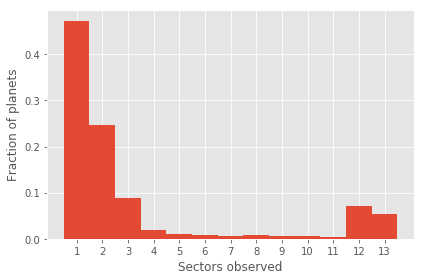

In [9]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1,1)
    h1 = ax.hist(detected_DF.nsectors, bins=np.arange(0.5,14.5,1), cumulative=False, normed=True)
    ax.set_xlabel('Sectors observed')
    ax.set_ylabel('Fraction of planets')
    ax.xaxis.set_ticks(range(1,14,1))
#     ax.xaxis.set_ticklabels(range(1,14,1))
    fig.tight_layout()
    fig.savefig('../plots/obs_len.png', dpi=200)

q = [print('{:.0f}: {:.1f}%'.format(np.round(h1[1][:-1]+0.5)[i],100*h1[0][i])) for i in range(13)]

In [10]:
print('stars brigter than T=9 is {}'.format(
    detected_DF.TESSMAG[(detected_DF.RADIUS>=0.8) * (detected_DF.TESSMAG<=9)].shape[0]))

stars brigter than T=9 is 217


/Users/tom/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


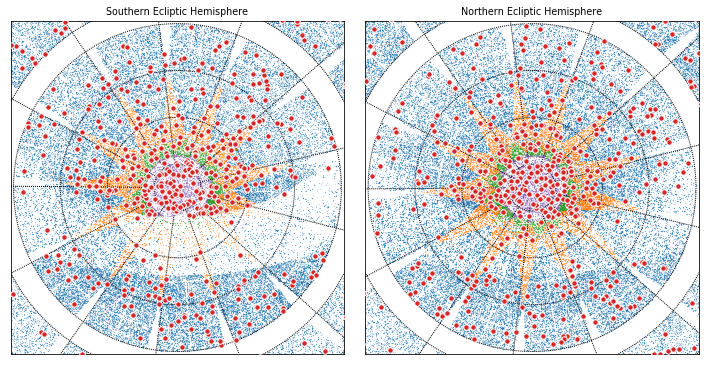

In [11]:

from mpl_toolkits.basemap import Basemap
with plt.style.context('seaborn-paper'):
    fig, [ax1, ax2] = plt.subplots(1,2, figsize=[10,5])
    m = Basemap(projection='aeqd',lon_0=0,lat_0=90,resolution='l', celestial=True, ax=ax2,
               width=19E6, height=19E6)
    m.scatter(newDF.ECLONG.values[newDF.nsectors == 1], newDF.ECLAT.values[newDF.nsectors == 1], 
              s=1.0, alpha=0.2, latlon=True)
    m.scatter(newDF.ECLONG.values[newDF.nsectors == 2], newDF.ECLAT.values[newDF.nsectors == 2], 
              s=1.0, alpha=0.2, latlon=True)
    m.scatter(newDF.ECLONG.values[newDF.nsectors ==3], newDF.ECLAT.values[newDF.nsectors ==3], 
              s=1.0, alpha=0.2, latlon=True)

    m.scatter(detected_DF.ECLONG.values, detected_DF.ECLAT.values, s=30, lw=1, edgecolor='w',
              alpha=1, latlon=True, zorder=100)
    m.scatter(newDF.ECLONG.values[newDF.nsectors >3], newDF.ECLAT.values[newDF.nsectors >3], 
              s=1.0, alpha=0.2, latlon=True)
    
    
    parallels = [-78., -54, -30, -6, 6, 30, 54, 78, ]
    m.drawparallels(parallels, latmax=78, )
    meridians = np.linspace(240-12,360+240-12,14)[:-1]
    m.drawmeridians(meridians,)

    m = Basemap(projection='aeqd',lon_0=0,lat_0=-90,resolution='l', ax=ax1, celestial=True,
               width=19E6, height=19E6)
    m.scatter(newDF.ECLONG.values[newDF.nsectors == 1], newDF.ECLAT.values[newDF.nsectors == 1], 
              s=1.0, alpha=0.2, latlon=True)
    m.scatter(newDF.ECLONG.values[newDF.nsectors == 2], newDF.ECLAT.values[newDF.nsectors == 2], 
              s=1.0, alpha=0.2, latlon=True)
    m.scatter(newDF.ECLONG.values[newDF.nsectors ==3], newDF.ECLAT.values[newDF.nsectors ==3], 
              s=1.0, alpha=0.2, latlon=True)

    m.scatter(detected_DF.ECLONG.values, detected_DF.ECLAT.values, lw=1, edgecolor='w',
              s=30, alpha=1, latlon=True, zorder=100)
    m.scatter(newDF.ECLONG.values[newDF.nsectors >3], newDF.ECLAT.values[newDF.nsectors >3], 
              s=1.0, alpha=0.2, latlon=True)
    
    parallels = [-78., -54., -30, -6., 6, 30, 54, 78, ]
    m.drawparallels(parallels, latmax=78, latmin=-78)
    meridians = np.linspace(240-12,360+240-12,14)[:-1]
    m.drawmeridians(meridians, latmax=78, latmin=-78)
    ax2.set_title('Northern Ecliptic Hemisphere')
    ax1.set_title('Southern Ecliptic Hemisphere')
    fig.tight_layout()
    fig.savefig('../plots/skyplot.png', dpi=200)

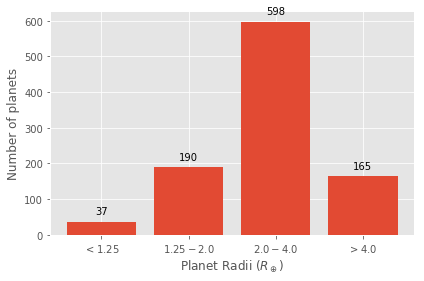

In [12]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 15+height,
                '%d' % int(height),
                ha='center', va='bottom')

counts = np.histogram(detected_DF.planetRadius, bins = [0,1.25,2,4,25])
tl = ['$<1.25$', '$1.25 - 2.0$', '$2.0 - 4.0$', '$>4.0$']
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1,1,)
    
    h1 = ax.bar(np.arange(4), counts[0], tick_label = tl, )
    ax.set_xlabel('Planet Radii ($ R_\oplus$)')
    ax.set_ylabel('Number of planets')
#     ax.set_xlim(0,6)
    fig.tight_layout()
#     fig.savefig('../plots/obs_len.png', dpi=200)
    autolabel(h1)
    fig.savefig('../plots/planet_sizes.png', dpi=200)


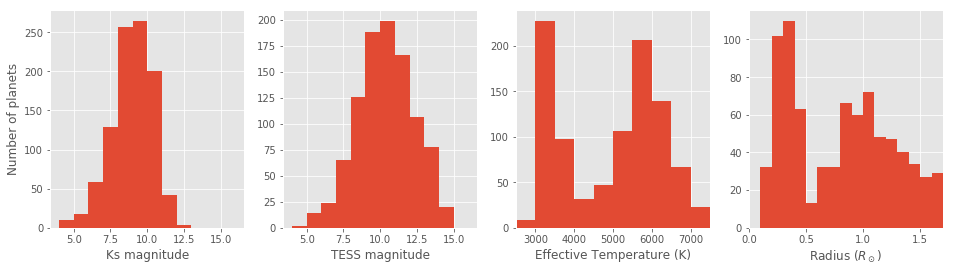

In [13]:
with plt.style.context('ggplot'):
    fig, [ax1,ax2,ax3,ax4] = plt.subplots(1,4,figsize=[16,4])
    
    h1 = ax1.hist(detected_DF.Ks, bins=np.arange(4,16.5,1))
    ax1.set_xlabel('Ks magnitude')
    ax1.set_ylabel('Number of planets')
    ax4.set_xlim(4,16.0)
    
    h2 = ax2.hist(detected_DF.TESSMAG, bins=np.arange(4,16.5,1))
    ax2.set_xlabel('TESS magnitude')
    ax4.set_xlim(4,16.0)
    
    h3 = ax3.hist(detected_DF.TEFF, bins=np.arange(2500,7500+250,500))
    ax3.set_xlabel('Effective Temperature (K)')
    ax3.set_xlim(2500,7500)
    
    h4 = ax4.hist(detected_DF.RADIUS, bins=np.arange(0,1.8,0.1))
    ax4.set_xlabel('Radius ($R_\odot$)')
    ax4.set_xlim(0,1.7)
    
    fig.savefig('../plots/host_stars.png', dpi=200)

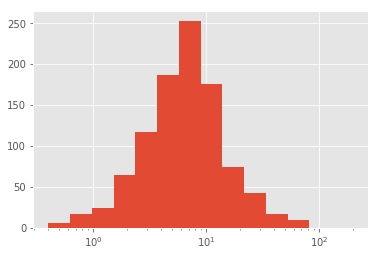

In [14]:
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1,1,)
    ax.set_xscale('log')
    ax.hist(detected_DF.planetPeriod, bins=np.logspace(np.log10(0.4),np.log10(200),15))

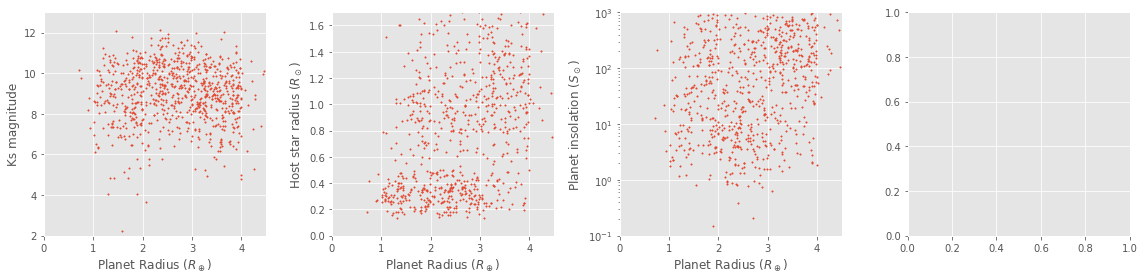

In [15]:
with plt.style.context('ggplot'):
    fig, [ax1,ax2,ax3,ax4] = plt.subplots(1,4,figsize=[16,4])
    ax1.scatter(detected_DF.planetRadius, detected_DF.Ks, s=2)
    ax1.set_xlim(0,4.5)
    ax1.set_ylim(2,13)
    ax1.set_xlabel('Planet Radius ($R_\oplus$)')
    ax1.set_ylabel('Ks magnitude')
    
    ax2.scatter(detected_DF.planetRadius, detected_DF.RADIUS, s=2)
    ax2.set_xlim(0,4.5)
    ax2.set_ylim(0,1.7)
    ax2.set_xlabel('Planet Radius ($R_\oplus$)')
    ax2.set_ylabel('Host star radius ($R_\odot$)')
    
    ax3.scatter(detected_DF.planetRadius, get_insol(detected_DF.TEFF, detected_DF.ars), s=2)
    ax3.set_xlim(0,4.5)
    ax3.set_ylim(0.1,1000)
    ax3.set_yscale("log",)
    ax3.set_xlabel('Planet Radius ($R_\oplus$)')
    ax3.set_ylabel('Planet insolation ($S_\odot$)')
    
    fig.tight_layout()

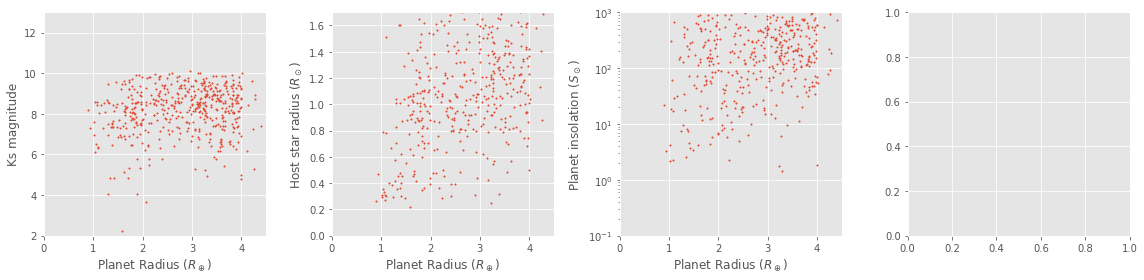

In [16]:
#bright stars
with plt.style.context('ggplot'):
    fig, [ax1,ax2,ax3,ax4] = plt.subplots(1,4,figsize=[16,4])
    ax1.scatter(brightstar_DF.planetRadius, brightstar_DF.Ks, s=2)
    ax1.set_xlim(0,4.5)
    ax1.set_ylim(2,13)
    ax1.set_xlabel('Planet Radius ($R_\oplus$)')
    ax1.set_ylabel('Ks magnitude')
    
    ax2.scatter(brightstar_DF.planetRadius, brightstar_DF.RADIUS, s=2)
    ax2.set_xlim(0,4.5)
    ax2.set_ylim(0,1.7)
    ax2.set_xlabel('Planet Radius ($R_\oplus$)')
    ax2.set_ylabel('Host star radius ($R_\odot$)')
    
    ax3.scatter(brightstar_DF.planetRadius, get_insol(brightstar_DF.TEFF, brightstar_DF.ars), s=2)
    ax3.set_xlim(0,4.5)
    ax3.set_ylim(0.1,1000)
    ax3.set_yscale("log",)
    ax3.set_xlabel('Planet Radius ($R_\oplus$)')
    ax3.set_ylabel('Planet insolation ($S_\odot$)')
    
    fig.tight_layout()

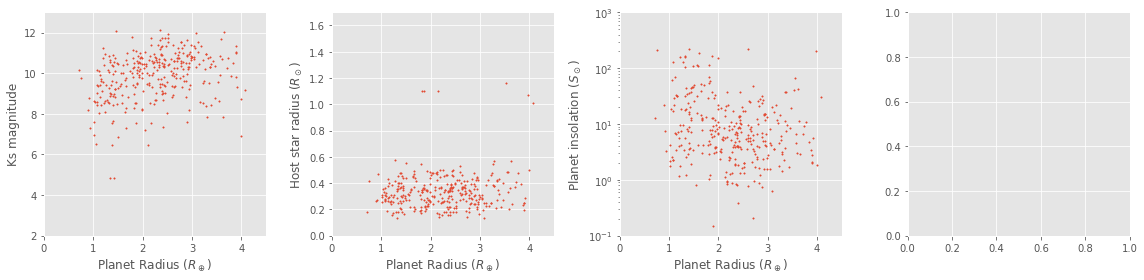

In [17]:
# m dwarfs
with plt.style.context('ggplot'):
    fig, [ax1,ax2,ax3,ax4] = plt.subplots(1,4,figsize=[16,4])
    ax1.scatter(coolstar_DF.planetRadius, coolstar_DF.Ks, s=2)
    ax1.set_xlim(0,4.5)
    ax1.set_ylim(2,13)
    ax1.set_xlabel('Planet Radius ($R_\oplus$)')
    ax1.set_ylabel('Ks magnitude')
    
    ax2.scatter(coolstar_DF.planetRadius, coolstar_DF.RADIUS, s=2)
    ax2.set_xlim(0,4.5)
    ax2.set_ylim(0,1.7)
    ax2.set_xlabel('Planet Radius ($R_\oplus$)')
    ax2.set_ylabel('Host star radius ($R_\odot$)')
    
    ax3.scatter(coolstar_DF.planetRadius, get_insol(coolstar_DF.TEFF, coolstar_DF.ars), s=2)
    ax3.set_xlim(0,4.5)
    ax3.set_ylim(0.1,1000)
    ax3.set_yscale("log",)
    ax3.set_xlabel('Planet Radius ($R_\oplus$)')
    ax3.set_ylabel('Planet insolation ($S_\odot$)')
    
    fig.tight_layout()

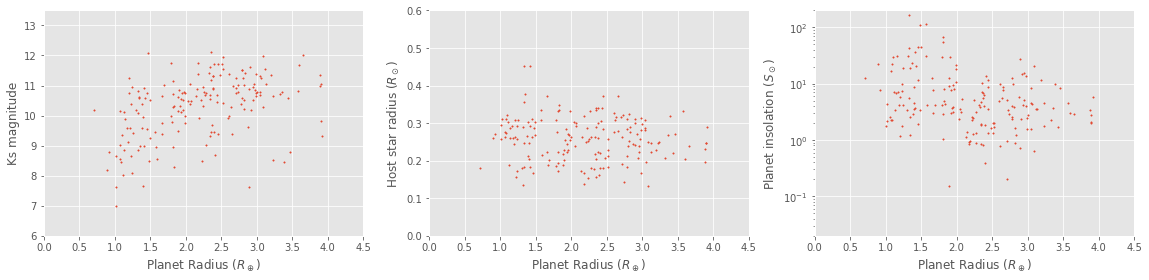

In [18]:
# later than M3
with plt.style.context('ggplot'):
    fig, [ax1,ax2,ax3] = plt.subplots(1,3,figsize=[16,4])
    ax1.scatter(verycool_df.planetRadius, verycool_df.Ks, s=2)
    ax1.set_xlim(0,4.5)
    ax1.set_ylim(6,13.5)
    ax1.set_xlabel('Planet Radius ($R_\oplus$)')
    ax1.set_ylabel('Ks magnitude')
    
    ax2.scatter(verycool_df.planetRadius, verycool_df.RADIUS, s=2)
    ax2.set_xlim(0,4.5)
    ax2.set_ylim(0,0.6)
    ax2.set_xlabel('Planet Radius ($R_\oplus$)')
    ax2.set_ylabel('Host star radius ($R_\odot$)')
    
    ax3.scatter(verycool_df.planetRadius, get_insol(verycool_df.TEFF, verycool_df.ars), s=2)
    ax3.set_xlim(0,4.5)
    ax3.set_ylim(0.02,200)
    ax3.set_yscale("log",)
    ax3.set_xlabel('Planet Radius ($R_\oplus$)')
    ax3.set_ylabel('Planet insolation ($S_\odot$)')
    
    fig.tight_layout()

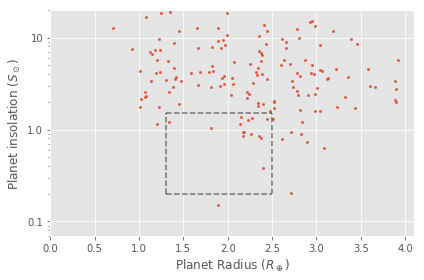

In [19]:
# later than M3
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1,1,figsize=[6,4])

    
    ax.scatter(verycool_df.planetRadius, get_insol(verycool_df.TEFF, verycool_df.ars), s=5)
    ax.set_xlim(0,4.1)
    ax.set_ylim(0.07,20)
    ax.set_yscale("log",)
    ax.set_xlabel('Planet Radius ($R_\oplus$)')
    ax.set_ylabel('Planet insolation ($S_\odot$)')
    ax.yaxis.set_ticklabels(['','','0.1','1.0','10'])
    
    ax.hlines(0.2,1.3,2.5, linestyles='--', alpha=0.5)
    ax.hlines(1.5,1.3,2.5, linestyles='--', alpha=0.5)
    ax.vlines(2.5,0.2,1.5, linestyles='--', alpha=0.5)
    ax.vlines(1.3,0.2,1.5, linestyles='--', alpha=0.5)

    fig.tight_layout()
    fig.savefig('../plots/cool_stars.png', dpi=200)
    
    q = ax.yaxis.get_ticklabels()

In [20]:
np.nonzero((verycool_df.planetRadius >=1.3) & 
 (verycool_df.planetRadius <=2.5) & (get_insol(verycool_df.TEFF, verycool_df.ars) >= 0.2) & 
 (get_insol(verycool_df.TEFF, verycool_df.ars)<1.5))[0].shape

(14,)

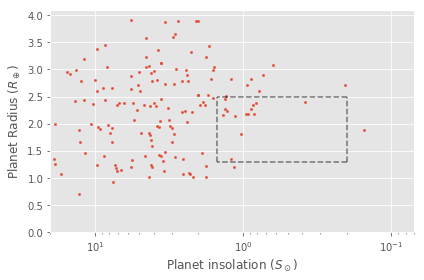

In [21]:
# later than M3
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1,1,figsize=[6,4])

    
    ax.scatter(get_insol(verycool_df.TEFF, verycool_df.ars), verycool_df.planetRadius, s=5)
    ax.set_ylim(0,4.1)
    ax.set_xlim(20,0.07)
    ax.set_xscale("log",)
    ax.set_ylabel('Planet Radius ($R_\oplus$)')
    ax.set_xlabel('Planet insolation ($S_\odot$)')
#     ax.yaxis.set_ticklabels(['','','0.1','1.0','10'])
    
    ax.vlines(0.2,1.3,2.5, linestyles='--', alpha=0.5)
    ax.vlines(1.5,1.3,2.5, linestyles='--', alpha=0.5)
    ax.hlines(2.5,0.2,1.5, linestyles='--', alpha=0.5)
    ax.hlines(1.3,0.2,1.5, linestyles='--', alpha=0.5)

    fig.tight_layout()
#     fig.savefig('../plots/cool_stars.png', dpi=200)
    

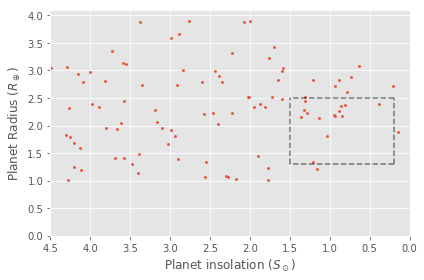

In [22]:
# later than M3
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1,1,figsize=[6,4])

    
    ax.scatter(get_insol(verycool_df.TEFF, verycool_df.ars), verycool_df.planetRadius, s=5)
    ax.set_ylim(0,4.1)
    ax.set_xlim(4.5,0.0)
#     ax.set_xscale("log",)
    ax.set_ylabel('Planet Radius ($R_\oplus$)')
    ax.set_xlabel('Planet insolation ($S_\odot$)')
#     ax.yaxis.set_ticklabels(['','','0.1','1.0','10'])
    
    ax.vlines(0.2,1.3,2.5, linestyles='--', alpha=0.5)
    ax.vlines(1.5,1.3,2.5, linestyles='--', alpha=0.5)
    ax.hlines(2.5,0.2,1.5, linestyles='--', alpha=0.5)
    ax.hlines(1.3,0.2,1.5, linestyles='--', alpha=0.5)

    fig.tight_layout()
#     fig.savefig('../plots/cool_stars.png', dpi=200)
    

In [11]:
td_a = detected_DF.transit_depth * 0.05


In [12]:
Wpspm2 = np.array([2.980e-11, 1.186e-11, 4.723e-12, 1.880e-12, 
                  7.486e-13 , 2.980e-13, 1.186e-13, 4.723e-14, 1.880e-14,  7.486e-15])

In [13]:
W = np.interp(detected_DF.TESSMAG, np.arange(6,16,1),Wpspm2)

In [20]:
x1 = W * 0.1* detected_DF.duration*86400 * 5E18 *detected_DF.transit_depth * 0.04 * 1.E-6 #* 0.2
x2 = W * 0.1* detected_DF.duration*86400 * 5E18 * 1.0 #* 0.2

print(np.where(x1/np.sqrt(x2) > 3.)[0].shape)

(277,)


In [21]:
(detected_DF.duration.iloc[np.where(x1/np.sqrt(x2) > 5.)[0]] *24 * 3).sum()

1118.286530278159

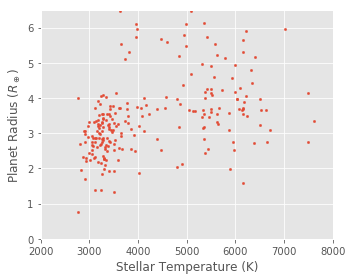

In [54]:
# later than M3
xd = np.where(x1/np.sqrt(x2) > 3.)[0]

with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1,1,figsize=[5,4])

#     ax.scatter(detected_DF.planetRadius,detected_DF.TEFF, s=5)
    ax.scatter(detected_DF.iloc[xd].TEFF, 
               detected_DF.iloc[xd].planetRadius + np.random.normal(0,0.2,xd.shape[0]), s=5)
    
    ax.set_xlim(2000,8000)
    ax.set_ylim(0,6.5)
#     ax.set_xscale("log",)
    ax.set_ylabel('Planet Radius ($R_\oplus$)')
    ax.set_xlabel('Stellar Temperature (K)')
# #     ax.yaxis.set_ticklabels(['','','0.1','1.0','10'])
    
#     ax.vlines(0.2,1.3,2.5, linestyles='--', alpha=0.5)
#     ax.vlines(1.5,1.3,2.5, linestyles='--', alpha=0.5)
#     ax.hlines(2.5,0.2,1.5, linestyles='--', alpha=0.5)
#     ax.hlines(1.3,0.2,1.5, linestyles='--', alpha=0.5)

    fig.tight_layout()
    fig.savefig('../plots/tide-detections.png', dpi=200)
    

In [73]:
detected_DF[detected_DF.TESSMAG <6]

,Unnamed: 0,Unnamed: 0.1,RA,DEC,ECLONG,ECLAT,Ks,TESSMAG,TEFF,RADIUS,...,rprs,impact,duration,duration_correction,transit_depth,transit_depth_diluted,needed_for_detection,has_transits,detected,nsectors
2717,2717,199502,346.723437,-38.892323,331.357662,-30.327956,5.457,5.641,10300.70,2.18585,...,0.014181,0.877083,0.099866,1.548153,201.090552,201.031434,104.431303,True,True,1.0
4186,4186,206299,279.055248,65.488739,347.928256,86.171401,5.314,5.729,7413.00,2.35674,...,0.009181,0.648389,0.192069,2.147011,84.282019,84.261452,213.184739,True,True,12.0
42248,42248,1571115,76.377818,-57.472721,48.685021,-78.941045,3.371,4.216,6153.02,1.11264,...,0.007943,0.668606,0.132674,1.784426,63.092417,63.012590,92.417533,True,True,13.0
42249,42249,1571115,76.377818,-57.472721,48.685021,-78.941045,3.371,4.216,6153.02,1.11264,...,0.014573,0.611228,0.132821,1.785412,212.381661,212.112948,344.119387,True,True,13.0
42624,42624,1573316,287.291257,76.560562,69.348032,78.704491,4.313,4.662,7493.00,1.55524,...,0.016722,0.665328,0.309186,2.724053,279.617232,279.542178,255.514539,True,True,13.0
42625,42625,1573316,287.291257,76.560562,69.348032,78.704491,4.313,4.662,7493.00,1.55524,...,0.023356,0.354847,0.282376,2.603270,545.509651,545.363228,727.689612,True,True,13.0
85560,85560,3055429,111.167475,-16.201471,116.010751,-37.748704,5.417,5.369,0.00,2.56323,...,0.027511,0.810325,0.217903,2.286850,756.838969,754.451473,409.361204,True,True,2.0
96751,96751,3405098,88.278633,-33.801365,87.357133,-57.224865,5.252,5.109,0.00,2.94112,...,0.039199,0.032358,0.353926,2.914485,1536.580019,1535.573734,1370.864649,True,True,2.0
96774,96774,3405167,233.987702,54.630577,197.180364,69.130973,5.625,5.693,9120.00,2.04681,...,0.050866,0.768385,0.135912,1.806072,2587.376767,2587.181226,2307.867257,True,True,2.0
135996,135996,4835722,24.428512,-57.236649,345.311412,-59.378067,0.880,1.315,12986.00,2.76791,...,0.011786,0.474043,0.306821,2.713614,138.915146,138.913191,89.439496,True,True,2.0


In [2]:
from astropy.coordinates import SkyCoord

In [17]:
pos = SkyCoord('55.0 -55.0', unit="deg")

In [20]:
pos.barycentrictrueecliptic.lat.value

-69.79359125327386

AttributeError: there are no boundary datasets associated with this Basemap instance

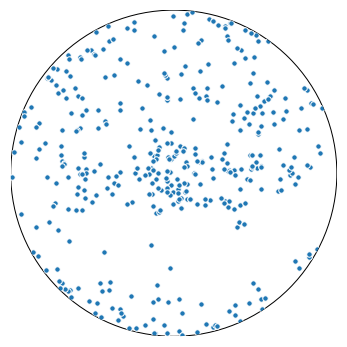

In [51]:
with plt.style.context('seaborn-paper'):
    fig, ax1 = plt.subplots(1,1, figsize=[6,6])
    m = Basemap(projection='ortho',lon_0=0,lat_0=-90,resolution='l', ax=ax1, celestial=True,
           )

    m.scatter(detected_DF.ECLONG.values, detected_DF.ECLAT.values, lw=1, edgecolor='w',
              s=30, alpha=1, latlon=True, zorder=100)
    
    m.contourf()
    
    parallels = [-78., -54., -30, -6.]
    m.drawparallels(parallels, latmax=78, latmin=-78)
    meridians = np.linspace(240-12,360+240-12,14)[:-1]
    m.drawmeridians(meridians, latmax=78, latmin=-78)
    ax1.set_title('Southern Ecliptic Hemisphere')
    fig.tight_layout()

In [18]:
df = pd.read_csv('/Users/tom/Dropbox/TIC5/ctl.csv', usecols=[27])

In [29]:
df['-4.6899949999999997'][df['-4.6899949999999997'] < (-90+17)].shape

(220201,)

In [25]:
np.sqrt(12**2 + 12**2)

16.970562748477139

In [28]:
90-17

73

In [16]:
q = detected_DF[['TESSMAG', 'Ks', 'transit_depth', 'planetPeriod', 'RADIUS','TEFF']]

In [17]:
q.to_csv('forJoshPepper.csv')

In [15]:
detected_DF[['RA', 'DEC', 'ECLONG', 'ECLAT', 'V', 'Ks',
       'TESSMAG', 'TEFF', 'RADIUS', 'MASS', 'CONTRATIO',
       'SELECTED', 'tess_ccd', 'obs_len', 'isMdwarf', 'cosi',
       'noise_level', 'Nplanets', 'planetRadius', 'planetPeriod', 'starID',
       'T0', 'Ntransits', 'ars', 'ecc', 'rprs', 'impact', 'duration',
       'duration_correction', 'transit_depth', 'transit_depth_diluted',
       'nsectors', 'omega']].to_csv('for_PayneHadden_v2.csv')

In [33]:
detected_DF.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'RA', 'DEC', 'ECLONG', 'ECLAT', 'V', 'Ks',
       'TESSMAG', 'TEFF', 'RADIUS', 'MASS', 'CONTRATIO', 'PRIORITY',
       'SELECTED', 'tess_ccd', 'obs_len', 'isMdwarf', 'isGiant', 'cosi',
       'noise_level', 'Nplanets', 'planetRadius', 'planetPeriod', 'starID',
       'T0', 'Ntransits', 'ars', 'ecc', 'omega', 'rprs', 'impact', 'duration',
       'duration_correction', 'transit_depth', 'transit_depth_diluted',
       'needed_for_detection', 'has_transits', 'detected', 'nsectors'],
      dtype='object')